# Import necessary modules

In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda
from tensorflow.keras.optimizers import Adam
# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [5]:
# Setting the input and output directory
INPUT_DIR = '/input/flickr8k'
OUTPUT_DIR = '/working'

# Image Features Extraction

In [4]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

In [5]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'wb'))

In [6]:
# Load features from pickle file
pickle_file_path = os.path.join("", "/working/features.pkl")
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Loading Caption Data

In [7]:
with open(os.path.join("", r"\flickr8k\captions.txt"), 'r') as file:
    next(file)
    captions_doc = file.read()

In [8]:
# Create mapping of image to captions
mapping = {}


# read lne by line (each line --> img.jpg, caption)
for line in tqdm(captions_doc.split('\n')) :
        # split at comma ','
        tokens = line.split(',')
        if len(line) < 2 :
            continue
        image_id , caption = tokens[0], tokens[1:]
        # now remove .jpg from image id
        image_id = image_id.split('.')[0]
        # convert captions list to string
        caption = " ".join(caption)
    
        # same image have multiple captions
        # create list
        if image_id not in mapping :
            mapping[image_id] = []
        # store the caption
        mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


#### So there are total 40455 captions for 8091 images that's means there are 5 captions for each image

# Preprocessing Captions: Getting Them Ready

Before we dive into the exciting world of creating captions for images, we need to prepare our captions so that our models can understand them. This process is known as preprocessing.

In [9]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [10]:
# before preprocess of text
mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [11]:
# preprocess the text
clean(mapping)

In [12]:
# after preprocess of text
mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [13]:
# Creating a List of All Captions
all_captions = [caption for captions in mapping.values() for caption in captions]

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [16]:
# Save the tokenizer
with open('/working/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('/working/tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [17]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


# Train Test Split

In [18]:
# Creating a List of Image IDs
image_ids = list(mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [20]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer="adam")

# Visualize the model
plot_model(model, show_shapes=True)
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256) 

In [21]:
# Set the number of epochs, batch size
epochs = 25
batch_size =  64

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/25
114/114 [==============================] - 31s 196ms/step - loss: 6.4918 - val_loss: 6.3318
Epoch 2/25
114/114 [==============================] - 20s 174ms/step - loss: 5.2455 - val_loss: 6.2664
Epoch 3/25
114/114 [==============================] - 20s 175ms/step - loss: 4.7865 - val_loss: 7.2042
Epoch 4/25
114/114 [==============================] - 20s 174ms/step - loss: 4.3918 - val_loss: 6.7077
Epoch 5/25
114/114 [==============================] - 20s 173ms/step - loss: 4.1318 - val_loss: 6.8765
Epoch 6/25
114/114 [==============================] - 20s 175ms/step - loss: 3.7713 - val_loss: 7.0668
Epoch 7/25
114/114 [==============================] - 20s 175ms/step - loss: 3.4634 - val_loss: 6.9900
Epoch 8/25
114/114 [==============================] - 20s 175ms/step - loss: 3.2117 - val_loss: 6.6726
Epoch 9/25
114/114 [==============================] - 20s 174ms/step - loss: 2.9412 - val_loss: 6.7933
Epoch 10/25
114/114 [==============================] - 20s 175ms/step - l

In [23]:
# Set the number of epochs, batch size
epochs = 15
batch_size =  64

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/15
114/114 [==============================] - 20s 175ms/step - loss: 0.9784 - val_loss: 9.8518
Epoch 2/15
114/114 [==============================] - 20s 175ms/step - loss: 0.8928 - val_loss: 10.1157
Epoch 3/15
114/114 [==============================] - 20s 175ms/step - loss: 0.8523 - val_loss: 9.3002
Epoch 4/15
114/114 [==============================] - 25s 218ms/step - loss: 0.7858 - val_loss: 9.9515
Epoch 5/15
114/114 [==============================] - 20s 179ms/step - loss: 0.7277 - val_loss: 10.3425
Epoch 6/15
114/114 [==============================] - 20s 176ms/step - loss: 0.6787 - val_loss: 11.1404
Epoch 7/15
114/114 [==============================] - 21s 187ms/step - loss: 0.6614 - val_loss: 11.0092
Epoch 8/15
114/114 [==============================] - 21s 183ms/step - loss: 0.6209 - val_loss: 11.2036
Epoch 9/15
114/114 [==============================] - 20s 175ms/step - loss: 0.5937 - val_loss: 11.0484
Epoch 10/15
114/114 [==============================] - 20s 175ms/st

In [22]:
# Save the model
model.save('/working/Attentionmodel.h5')

In [28]:
from keras.models import load_model
model = load_model('/working/Attentionmodel.h5')

# Captions Generation

In [29]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [30]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length,  padding="post")
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [31]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)


  0%|          | 0/810 [00:00<?, ?it/s]

In [32]:
# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0)))

BLEU-1: 0.486955
BLEU-2: 0.248119
BLEU-2: 0.140227


# Predicting captions for Images

In [69]:
import pyttsx3
def speak_text(text):
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait() 

In [65]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name) :
      # Loading image
      image_id = image_name.split('.')[0]
      image_path = os.path.join("/flickr8k/Images/", image_name)
      image = Image.open(image_path)
      captions = mapping[image_id]
    
      print("-----------Actual-----------------")
      for caption in captions :
        print(caption)
    
      y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
      y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip()
      print()
      plt.imshow(image)
      plt.show()
      print()
      print("-----------Predicted-----------------")
      print(y_pred) 
      print()
      speak_text(y_pred)

-----------Actual-----------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq



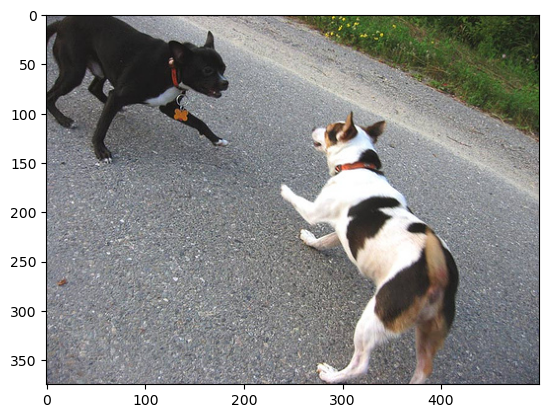


-----------Predicted-----------------
black dog and tricolored dog playing with each other on the road



In [70]:
generate_caption('1001773457_577c3a7d70.jpg')

-----------Actual-----------------
startseq person in blue jacket wearing bicycle helmet is riding bike endseq
startseq woman is riding her bicycle endseq
startseq woman riding bike in park endseq
startseq woman with blue jacket wears helmet as she rides bike endseq
startseq woman with helmet riding bike endseq



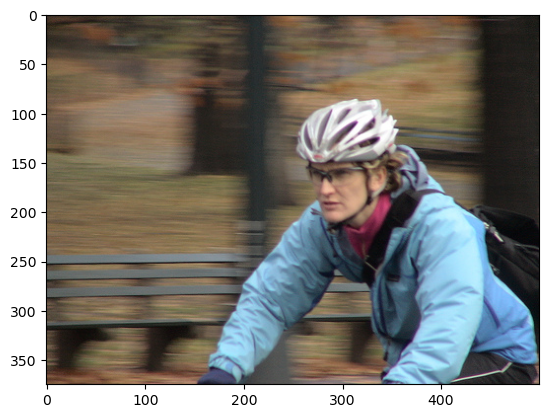


-----------Predicted-----------------
woman with backpacks in front of street



In [50]:
generate_caption('2084217208_7bd9bc85e5.jpg')

-----------Actual-----------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq



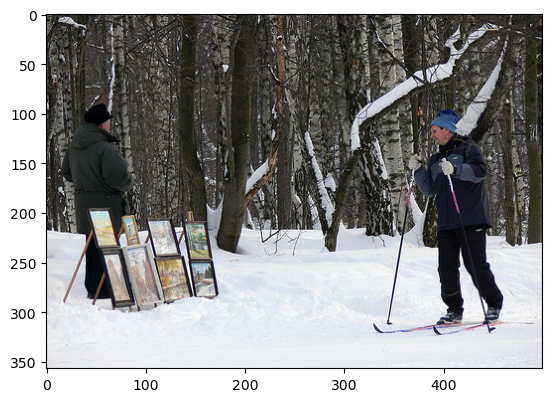


-----------Predicted-----------------
man skis past another man displaying paintings in the snow



In [51]:
generate_caption("101669240_b2d3e7f17b.jpg")

-----------Actual-----------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq



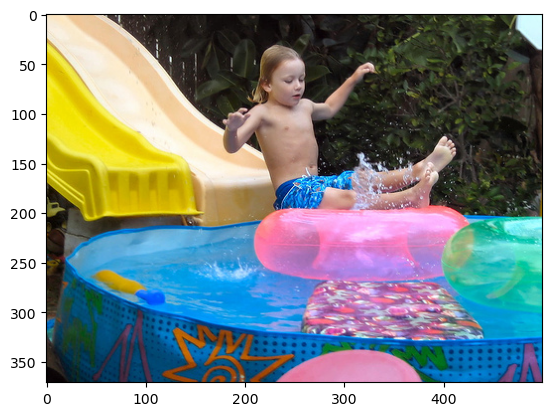


-----------Predicted-----------------
boy in blue shorts slides down slide into pool with colorful tubes



In [52]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq


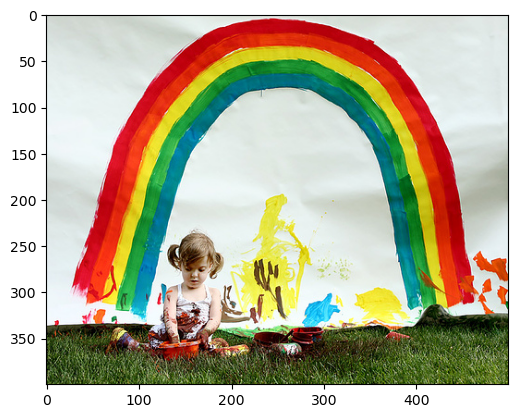

In [49]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man is standing in front of skyscraper endseq


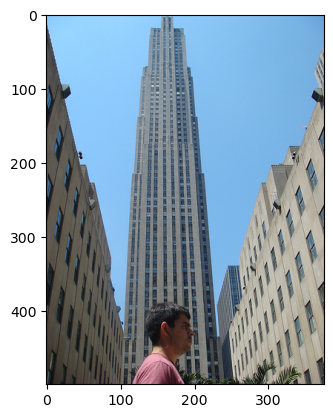

In [50]:
generate_caption("1032460886_4a598ed535.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq three dogs are standing on grassy hill while person kneels nearby endseq


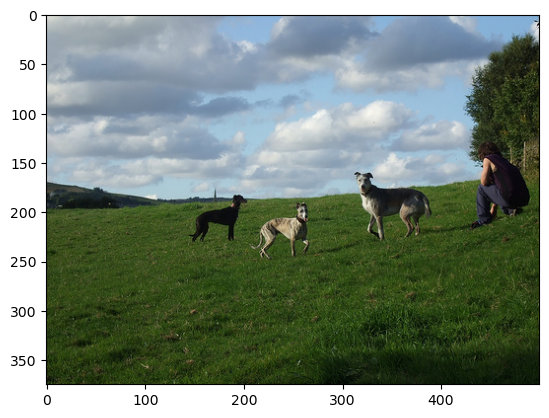

In [51]:
generate_caption("1032122270_ea6f0beedb.jpg")

---------------------Actual---------------------
startseq person in scuba suit holds very small lobster endseq
startseq scuba diver holds up small lobster underwater endseq
startseq scuba diver underwater holding small lobster endseq
startseq scuba diver under the water holding small crustacean in his hands endseq
startseq the scuba diver shows off something he found underwater endseq
--------------------Predicted--------------------
startseq man in the waves in the water and boy is on in front of him endseq


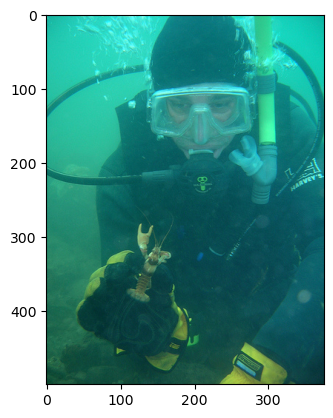

In [52]:
generate_caption('1480712062_32a61ad4b7.jpg')

---------------------Actual---------------------
startseq three children are jumping into the air into swimming pool at resort endseq
startseq three children are jumping into the water under palm tree endseq
startseq three children jumping into pool endseq
startseq three children jumping into pool with palm tree in the middle endseq
startseq three children jump into hotel pool from an artificial island endseq
--------------------Predicted--------------------
startseq the little boy is swimming in the water and small boy is jumping in the ocean endseq


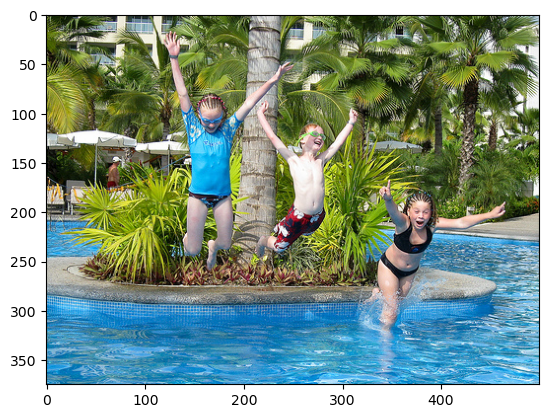

In [53]:
generate_caption('2081141788_38fa84ce3c.jpg')

---------------------Actual---------------------
startseq boy jumping off of cement block endseq
startseq boy plays with outstretched arms on the sidewalk next to cobblestone street endseq
startseq boy wearing blue tshirt is jumping up in the air on city street endseq
startseq boy with his arms stretched out to his left endseq
startseq young boy wearing blue jumps off of cement sidewalk endseq
--------------------Predicted--------------------
startseq little boy in blue shirt is wearing running on the beach endseq


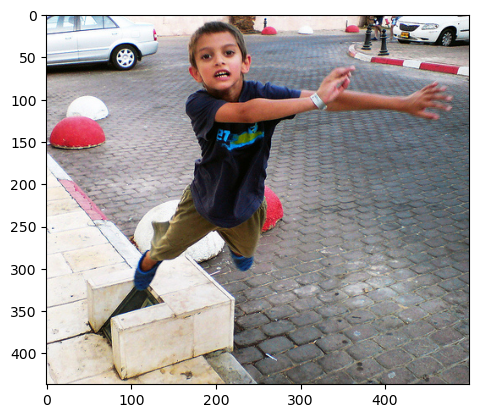

In [54]:
generate_caption('1414779054_31946f9dfc.jpg') 

---------------------Actual---------------------
startseq person on snowmobile in mid jump endseq
startseq snowmobiler flies through the air endseq
startseq snowmobile rider flies through the air on his or her machine in front of tall pine trees endseq
startseq rider jumps snowmobile high in rural area endseq
startseq the man is up in the air endseq
--------------------Predicted--------------------
startseq the man is up in the air endseq


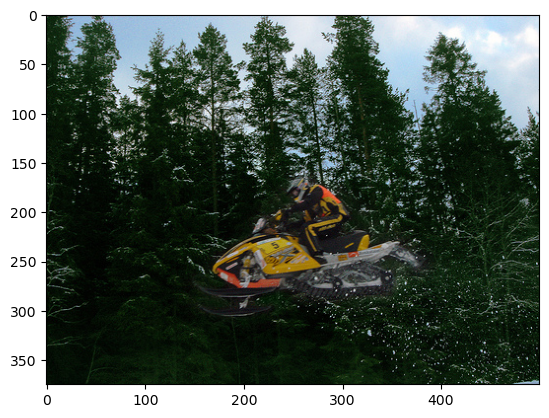

In [55]:
generate_caption('109738763_90541ef30d.jpg')

In [ ]:
import tensorflow as tf
import gdown

# Google Drive file ID
file_id = "19bWI7AMq4hLz62Mg5Tsagf9nUxrgWrGz"
download_url = f"https://drive.google.com/uc?id={file_id}"
model_path = "working/"  # Local file path where the model will be saved

try:
    # Download the file
    gdown.download(download_url, model_path, quiet=False)
    
    # Load the model
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
    print(model.summary())
except Exception as e:
    print("Error loading model:", str(e))
